# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

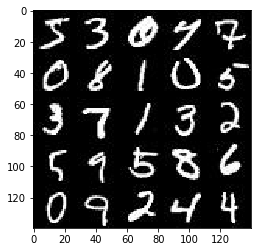

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

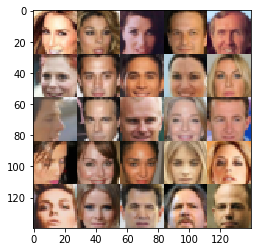

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.9170
Epoch 1/2... Discriminator Loss: 3.6248... Generator Loss: 0.0388
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 2.1520
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 4.1952
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 2.3798
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.4127
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 2.1988
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 2.1531
Epoch 1/2... Discriminator Loss: 0.5499... Generator Loss: 1.9780
Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 3.6707


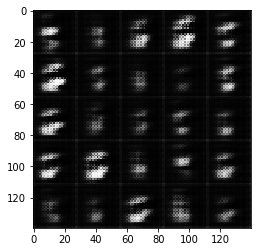

Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.7309
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 1.5654
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.7745
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 2.2403
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.9661
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.9093
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 3.0262


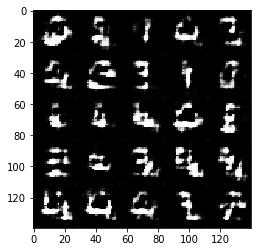

Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 2.7064
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4569
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 2.5295
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.4349


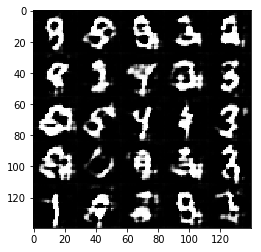

Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.0244
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.5091
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.1409
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.2722
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.8528


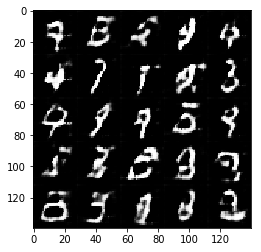

Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 1.7526
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.0388
Epoch 1/2... Discriminator Loss: 1.2764... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.7195
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 1.0185


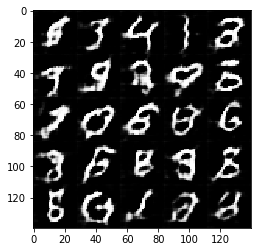

Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 1.9698
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.6833... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 1.5821


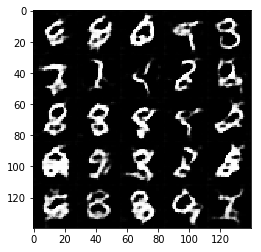

Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.6672
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.4326
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.7617... Generator Loss: 0.3326


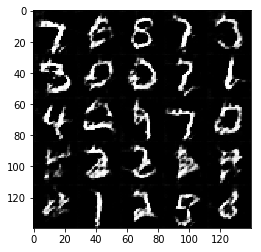

Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.5576
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.2990
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.2346
Epoch 1/2... Discriminator Loss: 1.6688... Generator Loss: 0.3647
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.4875


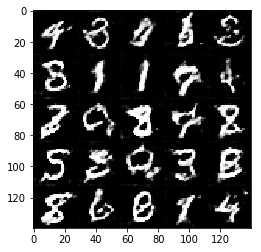

Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 1.6240... Generator Loss: 0.4672
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 1.9807
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.7472


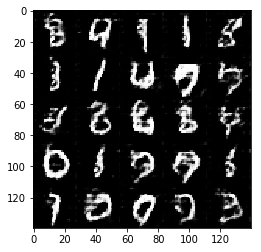

Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.8562
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 1.0550
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.8547


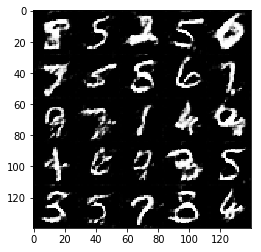

Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.8978
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.7388... Generator Loss: 0.3273
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.7898


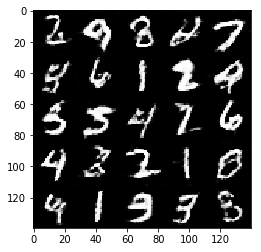

Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 0.5875... Generator Loss: 1.6984
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 1.2496
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.5528
Epoch 2/2... Discriminator Loss: 1.6642... Generator Loss: 0.3569
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 0.7537


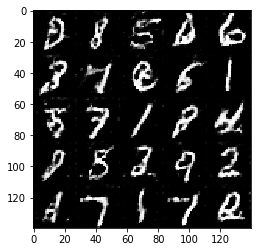

Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.5095
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.7000... Generator Loss: 0.3838
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.5687
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 2.2679... Generator Loss: 0.2079
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 2.1266
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.4444


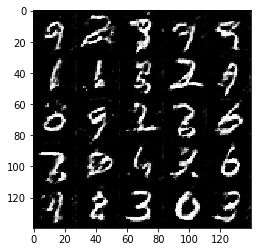

Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.4629
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.4623
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 1.0096


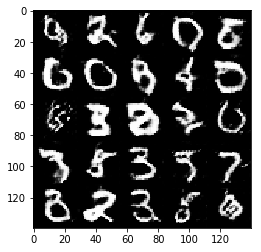

Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.6018... Generator Loss: 1.5980
Epoch 2/2... Discriminator Loss: 2.1975... Generator Loss: 0.2069
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 1.0646
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.5218


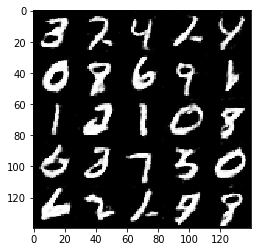

Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.7246... Generator Loss: 0.3489
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.4365
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 2.2315
Epoch 2/2... Discriminator Loss: 1.4857... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 1.6077... Generator Loss: 0.3943
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.7109


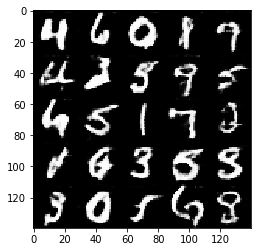

Epoch 2/2... Discriminator Loss: 1.6654... Generator Loss: 0.3673
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 1.6953... Generator Loss: 0.3482
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 1.8587
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.9533
Epoch 2/2... Discriminator Loss: 1.9759... Generator Loss: 0.2802


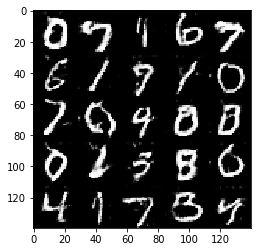

Epoch 2/2... Discriminator Loss: 1.8582... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.7024... Generator Loss: 0.3469
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 1.6397
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.6565... Generator Loss: 0.3991


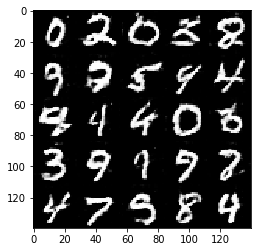

Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 0.4221
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.3271
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.6286
Epoch 2/2... Discriminator Loss: 1.7119... Generator Loss: 0.3580
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.5446


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 1.0041... Generator Loss: 0.9672
Epoch 1/10... Discriminator Loss: 0.7975... Generator Loss: 1.3586
Epoch 1/10... Discriminator Loss: 0.6455... Generator Loss: 1.7785
Epoch 1/10... Discriminator Loss: 0.6297... Generator Loss: 1.8506
Epoch 1/10... Discriminator Loss: 0.5127... Generator Loss: 2.2200
Epoch 1/10... Discriminator Loss: 0.6279... Generator Loss: 1.9334
Epoch 1/10... Discriminator Loss: 0.5104... Generator Loss: 2.3673
Epoch 1/10... Discriminator Loss: 0.7042... Generator Loss: 1.5240
Epoch 1/10... Discriminator Loss: 0.5632... Generator Loss: 1.9176
Epoch 1/10... Discriminator Loss: 1.1664... Generator Loss: 2.3700


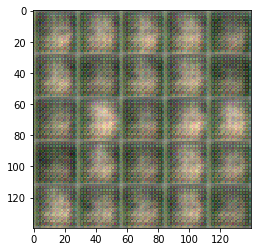

Epoch 1/10... Discriminator Loss: 0.7270... Generator Loss: 1.5494
Epoch 1/10... Discriminator Loss: 0.6814... Generator Loss: 1.8534
Epoch 1/10... Discriminator Loss: 0.9248... Generator Loss: 1.7828
Epoch 1/10... Discriminator Loss: 0.6443... Generator Loss: 1.8549
Epoch 1/10... Discriminator Loss: 0.8130... Generator Loss: 1.7198
Epoch 1/10... Discriminator Loss: 1.2263... Generator Loss: 2.1360
Epoch 1/10... Discriminator Loss: 0.7193... Generator Loss: 1.6850
Epoch 1/10... Discriminator Loss: 0.5711... Generator Loss: 2.2294
Epoch 1/10... Discriminator Loss: 0.8985... Generator Loss: 1.3038
Epoch 1/10... Discriminator Loss: 0.8992... Generator Loss: 1.3102


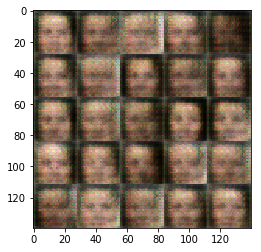

Epoch 1/10... Discriminator Loss: 0.9964... Generator Loss: 1.4212
Epoch 1/10... Discriminator Loss: 0.8776... Generator Loss: 1.2557
Epoch 1/10... Discriminator Loss: 0.9994... Generator Loss: 1.4289
Epoch 1/10... Discriminator Loss: 1.1373... Generator Loss: 0.9796
Epoch 1/10... Discriminator Loss: 0.6847... Generator Loss: 1.6246
Epoch 1/10... Discriminator Loss: 0.8048... Generator Loss: 1.5824
Epoch 1/10... Discriminator Loss: 0.8245... Generator Loss: 1.5665
Epoch 1/10... Discriminator Loss: 0.9583... Generator Loss: 1.1563
Epoch 1/10... Discriminator Loss: 0.7589... Generator Loss: 1.5348
Epoch 1/10... Discriminator Loss: 0.7489... Generator Loss: 1.4976


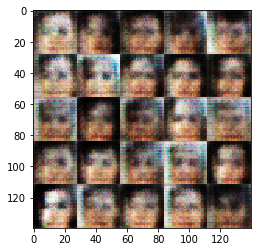

Epoch 1/10... Discriminator Loss: 0.7595... Generator Loss: 1.7762
Epoch 1/10... Discriminator Loss: 1.2486... Generator Loss: 1.1593
Epoch 1/10... Discriminator Loss: 1.2569... Generator Loss: 0.9694
Epoch 1/10... Discriminator Loss: 0.9950... Generator Loss: 1.0262
Epoch 1/10... Discriminator Loss: 1.0008... Generator Loss: 1.1556
Epoch 1/10... Discriminator Loss: 0.9457... Generator Loss: 1.3386
Epoch 1/10... Discriminator Loss: 1.1598... Generator Loss: 1.0736
Epoch 1/10... Discriminator Loss: 1.2290... Generator Loss: 1.2475
Epoch 1/10... Discriminator Loss: 0.9492... Generator Loss: 1.5598
Epoch 1/10... Discriminator Loss: 1.0491... Generator Loss: 1.1587


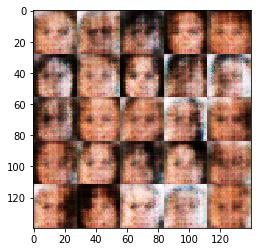

Epoch 1/10... Discriminator Loss: 1.2187... Generator Loss: 1.2205
Epoch 1/10... Discriminator Loss: 0.9213... Generator Loss: 1.0990
Epoch 1/10... Discriminator Loss: 1.1072... Generator Loss: 1.2635
Epoch 1/10... Discriminator Loss: 0.7605... Generator Loss: 1.6396
Epoch 1/10... Discriminator Loss: 1.1025... Generator Loss: 1.3738
Epoch 1/10... Discriminator Loss: 1.0230... Generator Loss: 1.2857
Epoch 1/10... Discriminator Loss: 0.8768... Generator Loss: 1.7292
Epoch 1/10... Discriminator Loss: 1.2111... Generator Loss: 0.8828
Epoch 1/10... Discriminator Loss: 0.9975... Generator Loss: 1.0553
Epoch 1/10... Discriminator Loss: 0.9805... Generator Loss: 1.4845


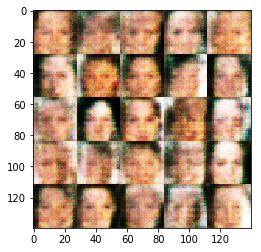

Epoch 1/10... Discriminator Loss: 1.2958... Generator Loss: 1.8440
Epoch 1/10... Discriminator Loss: 1.0602... Generator Loss: 1.2755
Epoch 1/10... Discriminator Loss: 1.0940... Generator Loss: 1.0695
Epoch 1/10... Discriminator Loss: 1.0904... Generator Loss: 1.3821
Epoch 1/10... Discriminator Loss: 0.9577... Generator Loss: 1.2896
Epoch 1/10... Discriminator Loss: 0.8662... Generator Loss: 1.4717
Epoch 1/10... Discriminator Loss: 0.8890... Generator Loss: 1.4915
Epoch 1/10... Discriminator Loss: 0.8606... Generator Loss: 1.4491
Epoch 1/10... Discriminator Loss: 1.0603... Generator Loss: 1.2396
Epoch 1/10... Discriminator Loss: 1.2311... Generator Loss: 1.3708


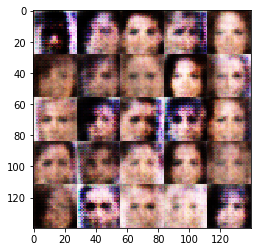

Epoch 1/10... Discriminator Loss: 1.1415... Generator Loss: 0.9582
Epoch 1/10... Discriminator Loss: 0.9346... Generator Loss: 1.1867
Epoch 1/10... Discriminator Loss: 1.0472... Generator Loss: 1.0955
Epoch 1/10... Discriminator Loss: 0.8886... Generator Loss: 1.3963
Epoch 1/10... Discriminator Loss: 0.9316... Generator Loss: 1.1787
Epoch 1/10... Discriminator Loss: 0.9064... Generator Loss: 1.3187
Epoch 1/10... Discriminator Loss: 1.3247... Generator Loss: 0.8037
Epoch 1/10... Discriminator Loss: 0.9760... Generator Loss: 1.5197
Epoch 1/10... Discriminator Loss: 0.9793... Generator Loss: 1.4934
Epoch 1/10... Discriminator Loss: 0.9467... Generator Loss: 1.1911


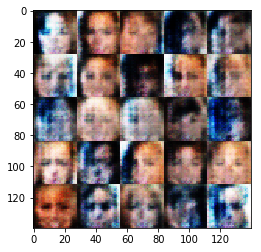

Epoch 1/10... Discriminator Loss: 1.2530... Generator Loss: 1.1065
Epoch 1/10... Discriminator Loss: 1.0295... Generator Loss: 1.4649
Epoch 1/10... Discriminator Loss: 0.9607... Generator Loss: 1.2830
Epoch 1/10... Discriminator Loss: 0.9994... Generator Loss: 1.1550
Epoch 1/10... Discriminator Loss: 1.1810... Generator Loss: 0.9992
Epoch 1/10... Discriminator Loss: 1.1078... Generator Loss: 0.9997
Epoch 1/10... Discriminator Loss: 0.9456... Generator Loss: 1.3471
Epoch 1/10... Discriminator Loss: 1.0358... Generator Loss: 1.1637
Epoch 1/10... Discriminator Loss: 1.0694... Generator Loss: 1.2109
Epoch 2/10... Discriminator Loss: 1.0211... Generator Loss: 1.3015


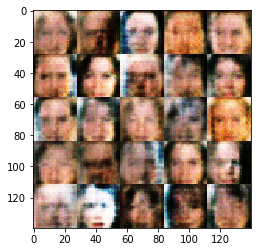

Epoch 2/10... Discriminator Loss: 1.1306... Generator Loss: 0.9258
Epoch 2/10... Discriminator Loss: 1.0664... Generator Loss: 0.9306
Epoch 2/10... Discriminator Loss: 1.1255... Generator Loss: 0.9384
Epoch 2/10... Discriminator Loss: 1.0826... Generator Loss: 1.0579
Epoch 2/10... Discriminator Loss: 1.2372... Generator Loss: 1.2071
Epoch 2/10... Discriminator Loss: 1.2125... Generator Loss: 1.3373
Epoch 2/10... Discriminator Loss: 0.9551... Generator Loss: 1.3622
Epoch 2/10... Discriminator Loss: 0.9036... Generator Loss: 1.4576
Epoch 2/10... Discriminator Loss: 1.0909... Generator Loss: 1.6253
Epoch 2/10... Discriminator Loss: 0.8950... Generator Loss: 1.3747


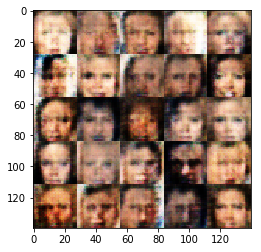

Epoch 2/10... Discriminator Loss: 1.1847... Generator Loss: 1.1192
Epoch 2/10... Discriminator Loss: 0.9597... Generator Loss: 1.1448
Epoch 2/10... Discriminator Loss: 1.1982... Generator Loss: 1.0235
Epoch 2/10... Discriminator Loss: 0.9737... Generator Loss: 1.3496
Epoch 2/10... Discriminator Loss: 1.0015... Generator Loss: 1.2006
Epoch 2/10... Discriminator Loss: 1.2509... Generator Loss: 0.9111
Epoch 2/10... Discriminator Loss: 1.1244... Generator Loss: 1.1412
Epoch 2/10... Discriminator Loss: 0.9740... Generator Loss: 1.0489
Epoch 2/10... Discriminator Loss: 1.1418... Generator Loss: 1.0183
Epoch 2/10... Discriminator Loss: 1.1024... Generator Loss: 1.4320


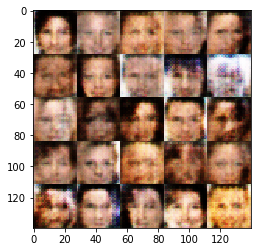

Epoch 2/10... Discriminator Loss: 1.0293... Generator Loss: 1.2398
Epoch 2/10... Discriminator Loss: 1.0626... Generator Loss: 1.1732
Epoch 2/10... Discriminator Loss: 1.1368... Generator Loss: 1.2899
Epoch 2/10... Discriminator Loss: 1.1098... Generator Loss: 1.0582
Epoch 2/10... Discriminator Loss: 1.0558... Generator Loss: 1.0930
Epoch 2/10... Discriminator Loss: 1.2019... Generator Loss: 0.8763
Epoch 2/10... Discriminator Loss: 0.9541... Generator Loss: 1.1988
Epoch 2/10... Discriminator Loss: 1.0441... Generator Loss: 1.2163
Epoch 2/10... Discriminator Loss: 0.9946... Generator Loss: 1.2233
Epoch 2/10... Discriminator Loss: 0.9818... Generator Loss: 1.0778


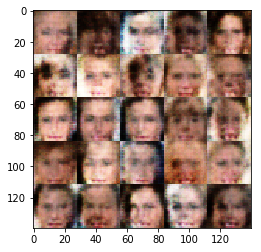

Epoch 2/10... Discriminator Loss: 1.1509... Generator Loss: 0.9733
Epoch 2/10... Discriminator Loss: 1.1454... Generator Loss: 1.0048
Epoch 2/10... Discriminator Loss: 0.9697... Generator Loss: 1.3337
Epoch 2/10... Discriminator Loss: 1.1386... Generator Loss: 1.0491
Epoch 2/10... Discriminator Loss: 1.1648... Generator Loss: 0.9143
Epoch 2/10... Discriminator Loss: 1.1414... Generator Loss: 1.9776
Epoch 2/10... Discriminator Loss: 1.0798... Generator Loss: 1.1700
Epoch 2/10... Discriminator Loss: 1.1475... Generator Loss: 0.9964
Epoch 2/10... Discriminator Loss: 1.0735... Generator Loss: 1.0781
Epoch 2/10... Discriminator Loss: 1.0985... Generator Loss: 1.0470


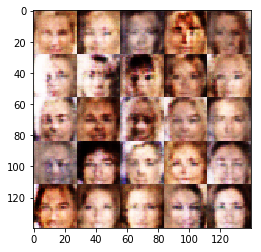

Epoch 2/10... Discriminator Loss: 1.1470... Generator Loss: 0.9057
Epoch 2/10... Discriminator Loss: 0.9971... Generator Loss: 1.1746
Epoch 2/10... Discriminator Loss: 1.1429... Generator Loss: 1.1729
Epoch 2/10... Discriminator Loss: 1.2840... Generator Loss: 0.5867
Epoch 2/10... Discriminator Loss: 1.1692... Generator Loss: 0.9235
Epoch 2/10... Discriminator Loss: 1.0205... Generator Loss: 1.4334
Epoch 2/10... Discriminator Loss: 1.0395... Generator Loss: 1.1547
Epoch 2/10... Discriminator Loss: 1.1162... Generator Loss: 1.6501
Epoch 2/10... Discriminator Loss: 1.0600... Generator Loss: 0.9853
Epoch 2/10... Discriminator Loss: 1.1125... Generator Loss: 1.2827


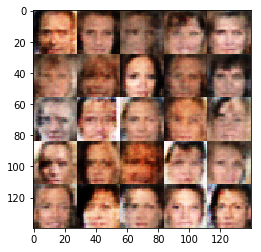

Epoch 2/10... Discriminator Loss: 1.1818... Generator Loss: 1.0696
Epoch 2/10... Discriminator Loss: 1.1447... Generator Loss: 1.1763
Epoch 2/10... Discriminator Loss: 1.1061... Generator Loss: 1.1950
Epoch 2/10... Discriminator Loss: 1.2164... Generator Loss: 0.8728
Epoch 2/10... Discriminator Loss: 0.9930... Generator Loss: 1.5696
Epoch 2/10... Discriminator Loss: 1.0617... Generator Loss: 1.2247
Epoch 2/10... Discriminator Loss: 0.9883... Generator Loss: 1.2289
Epoch 2/10... Discriminator Loss: 1.0150... Generator Loss: 1.1732
Epoch 2/10... Discriminator Loss: 1.1145... Generator Loss: 1.0392
Epoch 2/10... Discriminator Loss: 0.9629... Generator Loss: 1.2752


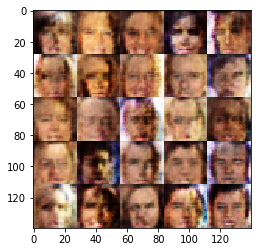

Epoch 2/10... Discriminator Loss: 1.1740... Generator Loss: 0.7128
Epoch 2/10... Discriminator Loss: 1.1650... Generator Loss: 0.9839
Epoch 2/10... Discriminator Loss: 1.1989... Generator Loss: 0.9755
Epoch 2/10... Discriminator Loss: 1.1425... Generator Loss: 0.8846
Epoch 2/10... Discriminator Loss: 1.1316... Generator Loss: 1.0761
Epoch 2/10... Discriminator Loss: 1.2241... Generator Loss: 0.7704
Epoch 2/10... Discriminator Loss: 1.0925... Generator Loss: 1.0915
Epoch 2/10... Discriminator Loss: 1.0539... Generator Loss: 1.0391
Epoch 2/10... Discriminator Loss: 1.0662... Generator Loss: 1.1738
Epoch 2/10... Discriminator Loss: 0.9735... Generator Loss: 1.1277


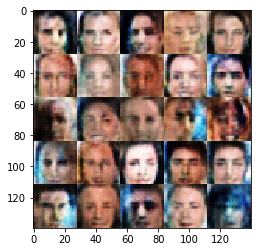

Epoch 2/10... Discriminator Loss: 1.2030... Generator Loss: 1.1376
Epoch 2/10... Discriminator Loss: 1.0707... Generator Loss: 1.2347
Epoch 2/10... Discriminator Loss: 1.1167... Generator Loss: 0.9546
Epoch 2/10... Discriminator Loss: 1.1462... Generator Loss: 1.1159
Epoch 2/10... Discriminator Loss: 1.1024... Generator Loss: 0.9019
Epoch 2/10... Discriminator Loss: 1.0642... Generator Loss: 1.0405
Epoch 2/10... Discriminator Loss: 1.1754... Generator Loss: 1.1472
Epoch 2/10... Discriminator Loss: 1.0775... Generator Loss: 1.2264
Epoch 3/10... Discriminator Loss: 1.1621... Generator Loss: 1.2287
Epoch 3/10... Discriminator Loss: 1.1631... Generator Loss: 1.3564


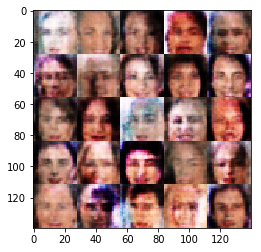

Epoch 3/10... Discriminator Loss: 1.1570... Generator Loss: 1.0527
Epoch 3/10... Discriminator Loss: 1.0543... Generator Loss: 1.2686
Epoch 3/10... Discriminator Loss: 1.0744... Generator Loss: 0.8449
Epoch 3/10... Discriminator Loss: 1.0432... Generator Loss: 1.3357
Epoch 3/10... Discriminator Loss: 1.0786... Generator Loss: 0.9333
Epoch 3/10... Discriminator Loss: 0.9347... Generator Loss: 1.2720
Epoch 3/10... Discriminator Loss: 1.2069... Generator Loss: 0.8452
Epoch 3/10... Discriminator Loss: 1.0695... Generator Loss: 0.9087
Epoch 3/10... Discriminator Loss: 1.0735... Generator Loss: 1.1191
Epoch 3/10... Discriminator Loss: 1.0751... Generator Loss: 1.4708


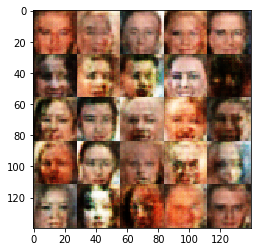

Epoch 3/10... Discriminator Loss: 1.1235... Generator Loss: 1.1196
Epoch 3/10... Discriminator Loss: 0.9974... Generator Loss: 1.0881
Epoch 3/10... Discriminator Loss: 1.1018... Generator Loss: 1.2146
Epoch 3/10... Discriminator Loss: 1.0690... Generator Loss: 1.3400
Epoch 3/10... Discriminator Loss: 1.2027... Generator Loss: 0.8152
Epoch 3/10... Discriminator Loss: 1.0573... Generator Loss: 1.2177
Epoch 3/10... Discriminator Loss: 1.0793... Generator Loss: 1.3903
Epoch 3/10... Discriminator Loss: 1.0126... Generator Loss: 1.1926
Epoch 3/10... Discriminator Loss: 0.9304... Generator Loss: 1.1908
Epoch 3/10... Discriminator Loss: 1.0446... Generator Loss: 1.0822


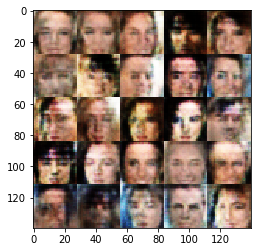

Epoch 3/10... Discriminator Loss: 0.9699... Generator Loss: 1.2192
Epoch 3/10... Discriminator Loss: 1.0644... Generator Loss: 1.1946
Epoch 3/10... Discriminator Loss: 1.2302... Generator Loss: 1.5515
Epoch 3/10... Discriminator Loss: 0.8510... Generator Loss: 1.5967
Epoch 3/10... Discriminator Loss: 1.0358... Generator Loss: 1.1872
Epoch 3/10... Discriminator Loss: 0.9451... Generator Loss: 1.3025
Epoch 3/10... Discriminator Loss: 1.4529... Generator Loss: 0.4711
Epoch 3/10... Discriminator Loss: 1.0564... Generator Loss: 1.1793
Epoch 3/10... Discriminator Loss: 1.1337... Generator Loss: 1.1114
Epoch 3/10... Discriminator Loss: 1.0790... Generator Loss: 0.9390


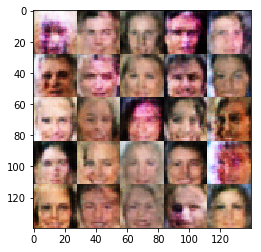

Epoch 3/10... Discriminator Loss: 1.0745... Generator Loss: 1.1618
Epoch 3/10... Discriminator Loss: 1.0997... Generator Loss: 0.9374
Epoch 3/10... Discriminator Loss: 1.1003... Generator Loss: 0.9650
Epoch 3/10... Discriminator Loss: 1.2115... Generator Loss: 1.3589
Epoch 3/10... Discriminator Loss: 1.1344... Generator Loss: 0.9745
Epoch 3/10... Discriminator Loss: 1.0215... Generator Loss: 1.1475
Epoch 3/10... Discriminator Loss: 1.0156... Generator Loss: 1.3401
Epoch 3/10... Discriminator Loss: 1.1003... Generator Loss: 1.0465
Epoch 3/10... Discriminator Loss: 1.1677... Generator Loss: 1.3359
Epoch 3/10... Discriminator Loss: 1.0161... Generator Loss: 1.2621


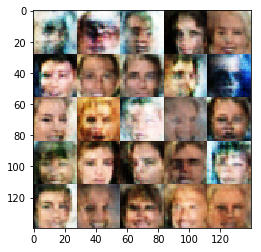

Epoch 3/10... Discriminator Loss: 1.0093... Generator Loss: 1.0234
Epoch 3/10... Discriminator Loss: 1.0147... Generator Loss: 0.9190
Epoch 3/10... Discriminator Loss: 1.0965... Generator Loss: 1.4800
Epoch 3/10... Discriminator Loss: 1.1138... Generator Loss: 0.8381
Epoch 3/10... Discriminator Loss: 1.1066... Generator Loss: 0.8747
Epoch 3/10... Discriminator Loss: 0.9838... Generator Loss: 1.1087
Epoch 3/10... Discriminator Loss: 1.1657... Generator Loss: 1.2293
Epoch 3/10... Discriminator Loss: 0.9816... Generator Loss: 1.2771
Epoch 3/10... Discriminator Loss: 1.0450... Generator Loss: 1.1163
Epoch 3/10... Discriminator Loss: 1.0523... Generator Loss: 1.0897


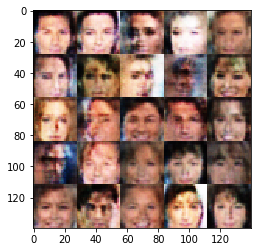

Epoch 3/10... Discriminator Loss: 1.1501... Generator Loss: 1.0586
Epoch 3/10... Discriminator Loss: 1.1054... Generator Loss: 0.8356
Epoch 3/10... Discriminator Loss: 0.9943... Generator Loss: 1.2478
Epoch 3/10... Discriminator Loss: 1.1148... Generator Loss: 0.8383
Epoch 3/10... Discriminator Loss: 1.0739... Generator Loss: 1.0123
Epoch 3/10... Discriminator Loss: 1.1401... Generator Loss: 1.0467
Epoch 3/10... Discriminator Loss: 1.0817... Generator Loss: 1.0056
Epoch 3/10... Discriminator Loss: 1.0384... Generator Loss: 1.3192
Epoch 3/10... Discriminator Loss: 1.1524... Generator Loss: 1.1264
Epoch 3/10... Discriminator Loss: 1.0046... Generator Loss: 1.3265


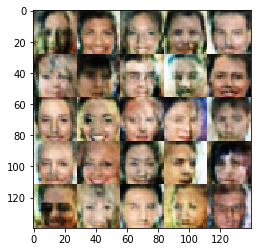

Epoch 3/10... Discriminator Loss: 1.1503... Generator Loss: 0.7906
Epoch 3/10... Discriminator Loss: 1.0958... Generator Loss: 1.0696
Epoch 3/10... Discriminator Loss: 1.1005... Generator Loss: 1.1362
Epoch 3/10... Discriminator Loss: 1.2171... Generator Loss: 0.7353
Epoch 3/10... Discriminator Loss: 1.1875... Generator Loss: 0.8220
Epoch 3/10... Discriminator Loss: 1.1454... Generator Loss: 1.1165
Epoch 3/10... Discriminator Loss: 1.2674... Generator Loss: 0.6570
Epoch 3/10... Discriminator Loss: 1.2010... Generator Loss: 1.2455
Epoch 3/10... Discriminator Loss: 1.1257... Generator Loss: 1.0281
Epoch 3/10... Discriminator Loss: 1.0168... Generator Loss: 1.0115


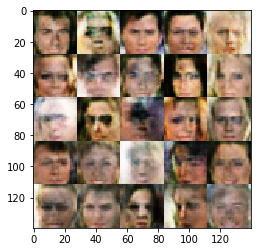

Epoch 3/10... Discriminator Loss: 1.1352... Generator Loss: 0.9062
Epoch 3/10... Discriminator Loss: 1.0020... Generator Loss: 1.2013
Epoch 3/10... Discriminator Loss: 1.0944... Generator Loss: 0.9437
Epoch 3/10... Discriminator Loss: 1.1051... Generator Loss: 1.2099
Epoch 3/10... Discriminator Loss: 0.9697... Generator Loss: 1.2761
Epoch 3/10... Discriminator Loss: 1.0178... Generator Loss: 1.0010
Epoch 3/10... Discriminator Loss: 1.1861... Generator Loss: 0.9128
Epoch 4/10... Discriminator Loss: 1.1184... Generator Loss: 0.8828
Epoch 4/10... Discriminator Loss: 1.1139... Generator Loss: 0.8580
Epoch 4/10... Discriminator Loss: 1.0621... Generator Loss: 1.0250


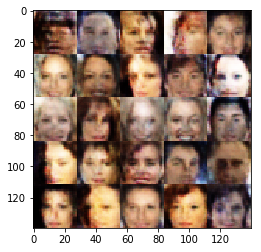

Epoch 4/10... Discriminator Loss: 1.0321... Generator Loss: 1.2806
Epoch 4/10... Discriminator Loss: 1.1119... Generator Loss: 1.2346
Epoch 4/10... Discriminator Loss: 1.0419... Generator Loss: 1.4642
Epoch 4/10... Discriminator Loss: 1.0300... Generator Loss: 1.2206
Epoch 4/10... Discriminator Loss: 1.0599... Generator Loss: 1.0382
Epoch 4/10... Discriminator Loss: 0.9710... Generator Loss: 1.3310
Epoch 4/10... Discriminator Loss: 1.2241... Generator Loss: 1.5564
Epoch 4/10... Discriminator Loss: 1.0016... Generator Loss: 1.1994
Epoch 4/10... Discriminator Loss: 1.2116... Generator Loss: 0.7717
Epoch 4/10... Discriminator Loss: 1.0780... Generator Loss: 1.4109


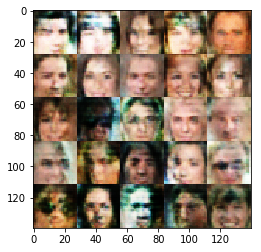

Epoch 4/10... Discriminator Loss: 1.1766... Generator Loss: 1.2235
Epoch 4/10... Discriminator Loss: 1.1393... Generator Loss: 0.8153
Epoch 4/10... Discriminator Loss: 1.0386... Generator Loss: 1.0349
Epoch 4/10... Discriminator Loss: 1.2253... Generator Loss: 0.7850
Epoch 4/10... Discriminator Loss: 1.2798... Generator Loss: 0.7773
Epoch 4/10... Discriminator Loss: 1.0288... Generator Loss: 0.9224
Epoch 4/10... Discriminator Loss: 1.2641... Generator Loss: 1.0918
Epoch 4/10... Discriminator Loss: 1.1249... Generator Loss: 0.8497
Epoch 4/10... Discriminator Loss: 1.2741... Generator Loss: 1.1951
Epoch 4/10... Discriminator Loss: 1.1960... Generator Loss: 1.2210


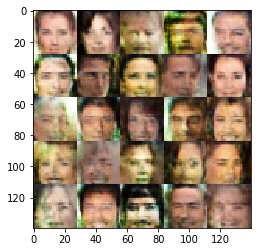

Epoch 4/10... Discriminator Loss: 1.0562... Generator Loss: 1.2019
Epoch 4/10... Discriminator Loss: 0.9975... Generator Loss: 1.2142
Epoch 4/10... Discriminator Loss: 1.1551... Generator Loss: 0.9058
Epoch 4/10... Discriminator Loss: 1.1511... Generator Loss: 0.8187
Epoch 4/10... Discriminator Loss: 1.1378... Generator Loss: 1.0411
Epoch 4/10... Discriminator Loss: 0.9533... Generator Loss: 1.1417
Epoch 4/10... Discriminator Loss: 1.1889... Generator Loss: 0.8346
Epoch 4/10... Discriminator Loss: 1.0916... Generator Loss: 1.2631
Epoch 4/10... Discriminator Loss: 1.0393... Generator Loss: 1.3215
Epoch 4/10... Discriminator Loss: 1.0412... Generator Loss: 1.1458


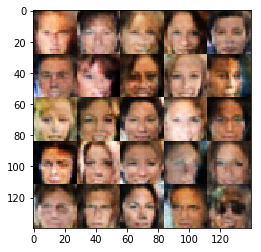

Epoch 4/10... Discriminator Loss: 1.1109... Generator Loss: 0.9233
Epoch 4/10... Discriminator Loss: 1.1030... Generator Loss: 1.1629
Epoch 4/10... Discriminator Loss: 1.0999... Generator Loss: 0.9758
Epoch 4/10... Discriminator Loss: 1.1112... Generator Loss: 1.0414
Epoch 4/10... Discriminator Loss: 1.0547... Generator Loss: 1.5983
Epoch 4/10... Discriminator Loss: 0.9874... Generator Loss: 1.1267
Epoch 4/10... Discriminator Loss: 1.0981... Generator Loss: 0.8111
Epoch 4/10... Discriminator Loss: 0.9847... Generator Loss: 1.1396
Epoch 4/10... Discriminator Loss: 1.1344... Generator Loss: 1.0146
Epoch 4/10... Discriminator Loss: 1.1949... Generator Loss: 1.2011


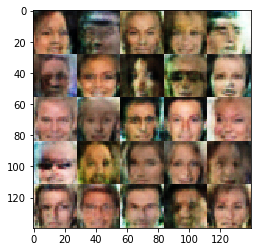

Epoch 4/10... Discriminator Loss: 1.0580... Generator Loss: 1.0498
Epoch 4/10... Discriminator Loss: 1.0811... Generator Loss: 1.0886
Epoch 4/10... Discriminator Loss: 0.9104... Generator Loss: 1.6596
Epoch 4/10... Discriminator Loss: 1.0581... Generator Loss: 1.3181
Epoch 4/10... Discriminator Loss: 1.1059... Generator Loss: 1.3162
Epoch 4/10... Discriminator Loss: 1.1212... Generator Loss: 0.9622
Epoch 4/10... Discriminator Loss: 1.0581... Generator Loss: 1.0787
Epoch 4/10... Discriminator Loss: 0.9815... Generator Loss: 1.0850
Epoch 4/10... Discriminator Loss: 1.0659... Generator Loss: 0.9269
Epoch 4/10... Discriminator Loss: 1.0272... Generator Loss: 1.2142


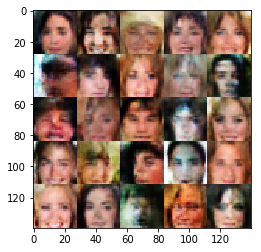

Epoch 4/10... Discriminator Loss: 1.1964... Generator Loss: 1.0313
Epoch 4/10... Discriminator Loss: 1.1293... Generator Loss: 0.9704
Epoch 4/10... Discriminator Loss: 1.0303... Generator Loss: 1.0798
Epoch 4/10... Discriminator Loss: 0.9252... Generator Loss: 1.3192
Epoch 4/10... Discriminator Loss: 1.0249... Generator Loss: 1.0632
Epoch 4/10... Discriminator Loss: 1.0038... Generator Loss: 1.3361
Epoch 4/10... Discriminator Loss: 1.0882... Generator Loss: 0.9621
Epoch 4/10... Discriminator Loss: 1.2698... Generator Loss: 0.9538
Epoch 4/10... Discriminator Loss: 1.0377... Generator Loss: 1.1762
Epoch 4/10... Discriminator Loss: 1.1116... Generator Loss: 1.2997


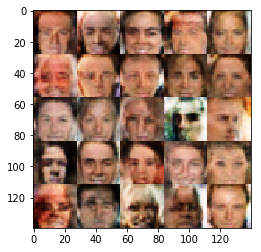

Epoch 4/10... Discriminator Loss: 1.1398... Generator Loss: 1.3759
Epoch 4/10... Discriminator Loss: 1.0715... Generator Loss: 0.8913
Epoch 4/10... Discriminator Loss: 1.0824... Generator Loss: 1.1177
Epoch 4/10... Discriminator Loss: 1.0109... Generator Loss: 1.0865
Epoch 4/10... Discriminator Loss: 1.0901... Generator Loss: 1.0034
Epoch 4/10... Discriminator Loss: 1.0306... Generator Loss: 1.2519
Epoch 4/10... Discriminator Loss: 1.0863... Generator Loss: 1.0988
Epoch 4/10... Discriminator Loss: 1.0777... Generator Loss: 1.1309
Epoch 4/10... Discriminator Loss: 0.9435... Generator Loss: 1.1622
Epoch 4/10... Discriminator Loss: 1.2870... Generator Loss: 1.4618


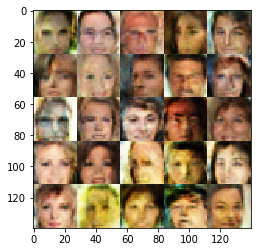

Epoch 4/10... Discriminator Loss: 1.1838... Generator Loss: 1.0096
Epoch 4/10... Discriminator Loss: 1.0798... Generator Loss: 1.0134
Epoch 4/10... Discriminator Loss: 1.0966... Generator Loss: 0.9233
Epoch 4/10... Discriminator Loss: 1.3119... Generator Loss: 1.3477
Epoch 4/10... Discriminator Loss: 1.1063... Generator Loss: 0.8539
Epoch 4/10... Discriminator Loss: 1.1129... Generator Loss: 1.0020
Epoch 5/10... Discriminator Loss: 1.0249... Generator Loss: 1.0441
Epoch 5/10... Discriminator Loss: 1.1592... Generator Loss: 1.0111
Epoch 5/10... Discriminator Loss: 0.9450... Generator Loss: 1.2183
Epoch 5/10... Discriminator Loss: 1.0963... Generator Loss: 0.9350


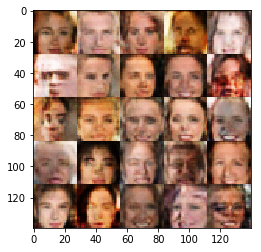

Epoch 5/10... Discriminator Loss: 1.0525... Generator Loss: 1.0447
Epoch 5/10... Discriminator Loss: 1.0812... Generator Loss: 1.0351
Epoch 5/10... Discriminator Loss: 1.1734... Generator Loss: 0.8110
Epoch 5/10... Discriminator Loss: 1.1313... Generator Loss: 0.9290
Epoch 5/10... Discriminator Loss: 1.2576... Generator Loss: 0.6492
Epoch 5/10... Discriminator Loss: 1.1607... Generator Loss: 0.8543
Epoch 5/10... Discriminator Loss: 1.0823... Generator Loss: 1.0808
Epoch 5/10... Discriminator Loss: 1.0569... Generator Loss: 0.9558
Epoch 5/10... Discriminator Loss: 1.1553... Generator Loss: 1.0086
Epoch 5/10... Discriminator Loss: 1.0451... Generator Loss: 1.1200


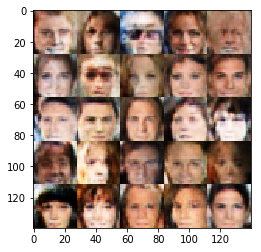

Epoch 5/10... Discriminator Loss: 1.1499... Generator Loss: 0.7818
Epoch 5/10... Discriminator Loss: 1.0508... Generator Loss: 1.2505
Epoch 5/10... Discriminator Loss: 0.9428... Generator Loss: 1.6073
Epoch 5/10... Discriminator Loss: 1.0156... Generator Loss: 1.0206
Epoch 5/10... Discriminator Loss: 1.1714... Generator Loss: 0.8454
Epoch 5/10... Discriminator Loss: 1.2184... Generator Loss: 0.8709
Epoch 5/10... Discriminator Loss: 1.0996... Generator Loss: 0.9050
Epoch 5/10... Discriminator Loss: 1.0929... Generator Loss: 1.1475
Epoch 5/10... Discriminator Loss: 1.0476... Generator Loss: 1.1344
Epoch 5/10... Discriminator Loss: 1.2274... Generator Loss: 0.7471


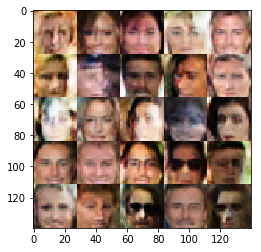

Epoch 5/10... Discriminator Loss: 1.1932... Generator Loss: 1.3927
Epoch 5/10... Discriminator Loss: 1.0085... Generator Loss: 0.9824
Epoch 5/10... Discriminator Loss: 0.8589... Generator Loss: 1.7834
Epoch 5/10... Discriminator Loss: 1.0235... Generator Loss: 0.9899
Epoch 5/10... Discriminator Loss: 1.1628... Generator Loss: 0.8800
Epoch 5/10... Discriminator Loss: 1.1103... Generator Loss: 0.9691
Epoch 5/10... Discriminator Loss: 1.0030... Generator Loss: 1.2575
Epoch 5/10... Discriminator Loss: 1.0529... Generator Loss: 1.0958
Epoch 5/10... Discriminator Loss: 1.1187... Generator Loss: 0.9833
Epoch 5/10... Discriminator Loss: 1.0697... Generator Loss: 0.9216


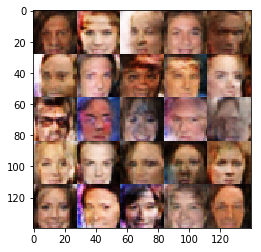

Epoch 5/10... Discriminator Loss: 1.0827... Generator Loss: 0.9331
Epoch 5/10... Discriminator Loss: 1.0971... Generator Loss: 0.9773
Epoch 5/10... Discriminator Loss: 1.1904... Generator Loss: 0.8978
Epoch 5/10... Discriminator Loss: 1.0894... Generator Loss: 0.9541
Epoch 5/10... Discriminator Loss: 1.0273... Generator Loss: 1.1667
Epoch 5/10... Discriminator Loss: 0.9983... Generator Loss: 1.1554
Epoch 5/10... Discriminator Loss: 1.0193... Generator Loss: 1.1824
Epoch 5/10... Discriminator Loss: 1.0672... Generator Loss: 1.2212
Epoch 5/10... Discriminator Loss: 1.1319... Generator Loss: 0.8041
Epoch 5/10... Discriminator Loss: 1.1985... Generator Loss: 0.8006


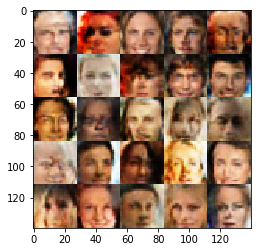

Epoch 5/10... Discriminator Loss: 1.0426... Generator Loss: 1.1908
Epoch 5/10... Discriminator Loss: 1.0898... Generator Loss: 0.9253
Epoch 5/10... Discriminator Loss: 1.1175... Generator Loss: 1.0398
Epoch 5/10... Discriminator Loss: 1.1681... Generator Loss: 0.8152
Epoch 5/10... Discriminator Loss: 1.0029... Generator Loss: 1.2408
Epoch 5/10... Discriminator Loss: 1.2872... Generator Loss: 0.6793
Epoch 5/10... Discriminator Loss: 1.1156... Generator Loss: 1.3489
Epoch 5/10... Discriminator Loss: 0.9488... Generator Loss: 1.2308
Epoch 5/10... Discriminator Loss: 0.9885... Generator Loss: 1.1355
Epoch 5/10... Discriminator Loss: 1.3073... Generator Loss: 0.6148


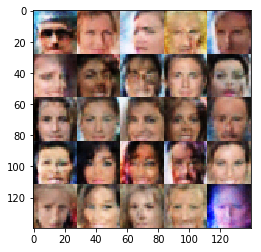

Epoch 5/10... Discriminator Loss: 1.1373... Generator Loss: 1.0101
Epoch 5/10... Discriminator Loss: 1.1364... Generator Loss: 1.2767
Epoch 5/10... Discriminator Loss: 1.1949... Generator Loss: 1.0064
Epoch 5/10... Discriminator Loss: 1.2385... Generator Loss: 0.6945
Epoch 5/10... Discriminator Loss: 1.0804... Generator Loss: 0.9800
Epoch 5/10... Discriminator Loss: 1.0119... Generator Loss: 1.2858
Epoch 5/10... Discriminator Loss: 1.0849... Generator Loss: 0.8963
Epoch 5/10... Discriminator Loss: 0.9964... Generator Loss: 1.0114
Epoch 5/10... Discriminator Loss: 1.1368... Generator Loss: 1.0763
Epoch 5/10... Discriminator Loss: 1.1124... Generator Loss: 0.8586


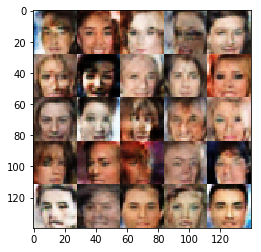

Epoch 5/10... Discriminator Loss: 1.0976... Generator Loss: 0.9269
Epoch 5/10... Discriminator Loss: 1.1713... Generator Loss: 0.8429
Epoch 5/10... Discriminator Loss: 1.1604... Generator Loss: 0.9026
Epoch 5/10... Discriminator Loss: 1.1524... Generator Loss: 1.3037
Epoch 5/10... Discriminator Loss: 1.2104... Generator Loss: 0.8136
Epoch 5/10... Discriminator Loss: 1.0665... Generator Loss: 1.1276
Epoch 5/10... Discriminator Loss: 1.1282... Generator Loss: 0.8153
Epoch 5/10... Discriminator Loss: 1.1740... Generator Loss: 0.7871
Epoch 5/10... Discriminator Loss: 1.1619... Generator Loss: 0.7188
Epoch 5/10... Discriminator Loss: 1.0852... Generator Loss: 0.9696


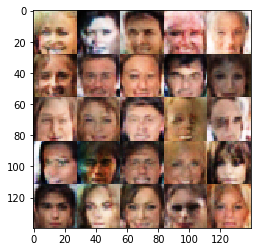

Epoch 5/10... Discriminator Loss: 1.0412... Generator Loss: 0.9056
Epoch 5/10... Discriminator Loss: 0.9907... Generator Loss: 1.2503
Epoch 5/10... Discriminator Loss: 1.0898... Generator Loss: 0.8813
Epoch 5/10... Discriminator Loss: 1.0358... Generator Loss: 1.0802
Epoch 5/10... Discriminator Loss: 1.1396... Generator Loss: 0.9157
Epoch 6/10... Discriminator Loss: 0.9624... Generator Loss: 1.3571
Epoch 6/10... Discriminator Loss: 1.1279... Generator Loss: 1.0070
Epoch 6/10... Discriminator Loss: 1.0561... Generator Loss: 1.1288
Epoch 6/10... Discriminator Loss: 1.1615... Generator Loss: 1.1162
Epoch 6/10... Discriminator Loss: 1.0411... Generator Loss: 1.2006


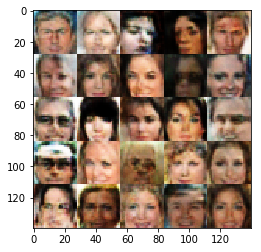

Epoch 6/10... Discriminator Loss: 0.9970... Generator Loss: 1.1500
Epoch 6/10... Discriminator Loss: 1.1447... Generator Loss: 0.8325
Epoch 6/10... Discriminator Loss: 1.1526... Generator Loss: 0.8949
Epoch 6/10... Discriminator Loss: 0.8549... Generator Loss: 1.2929
Epoch 6/10... Discriminator Loss: 1.0606... Generator Loss: 1.4110
Epoch 6/10... Discriminator Loss: 1.2868... Generator Loss: 0.5894
Epoch 6/10... Discriminator Loss: 1.0858... Generator Loss: 0.9726
Epoch 6/10... Discriminator Loss: 0.9996... Generator Loss: 1.4044
Epoch 6/10... Discriminator Loss: 1.0855... Generator Loss: 1.5122
Epoch 6/10... Discriminator Loss: 1.0176... Generator Loss: 1.2188


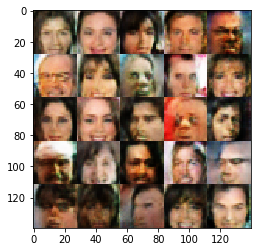

Epoch 6/10... Discriminator Loss: 1.1520... Generator Loss: 0.7375
Epoch 6/10... Discriminator Loss: 1.1864... Generator Loss: 0.8368
Epoch 6/10... Discriminator Loss: 1.0155... Generator Loss: 1.1465
Epoch 6/10... Discriminator Loss: 1.0346... Generator Loss: 1.0886
Epoch 6/10... Discriminator Loss: 1.2445... Generator Loss: 1.4592
Epoch 6/10... Discriminator Loss: 1.0049... Generator Loss: 1.1854
Epoch 6/10... Discriminator Loss: 1.1220... Generator Loss: 0.9248
Epoch 6/10... Discriminator Loss: 1.1026... Generator Loss: 0.9575
Epoch 6/10... Discriminator Loss: 0.8551... Generator Loss: 1.5963
Epoch 6/10... Discriminator Loss: 1.3245... Generator Loss: 0.6079


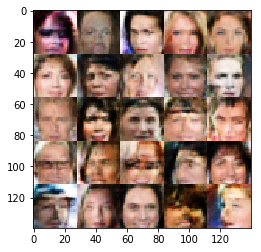

Epoch 6/10... Discriminator Loss: 1.0287... Generator Loss: 0.8955
Epoch 6/10... Discriminator Loss: 1.1816... Generator Loss: 0.7099
Epoch 6/10... Discriminator Loss: 1.2389... Generator Loss: 0.8450
Epoch 6/10... Discriminator Loss: 1.0454... Generator Loss: 1.1525
Epoch 6/10... Discriminator Loss: 1.0059... Generator Loss: 1.1291
Epoch 6/10... Discriminator Loss: 1.2429... Generator Loss: 0.7867
Epoch 6/10... Discriminator Loss: 1.2804... Generator Loss: 0.6146
Epoch 6/10... Discriminator Loss: 1.0671... Generator Loss: 0.9339
Epoch 6/10... Discriminator Loss: 1.0654... Generator Loss: 1.1382
Epoch 6/10... Discriminator Loss: 1.0717... Generator Loss: 1.0202


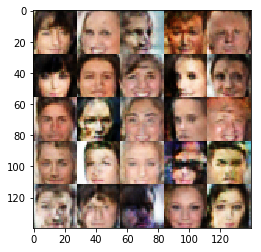

Epoch 6/10... Discriminator Loss: 1.0317... Generator Loss: 0.9643
Epoch 6/10... Discriminator Loss: 1.1504... Generator Loss: 0.9713
Epoch 6/10... Discriminator Loss: 1.1292... Generator Loss: 0.8453
Epoch 6/10... Discriminator Loss: 1.0399... Generator Loss: 1.3989
Epoch 6/10... Discriminator Loss: 1.2287... Generator Loss: 0.8200
Epoch 6/10... Discriminator Loss: 1.1680... Generator Loss: 0.8793
Epoch 6/10... Discriminator Loss: 1.0535... Generator Loss: 1.1815
Epoch 6/10... Discriminator Loss: 1.0293... Generator Loss: 1.1771
Epoch 6/10... Discriminator Loss: 1.1537... Generator Loss: 1.1163
Epoch 6/10... Discriminator Loss: 1.0792... Generator Loss: 1.1226


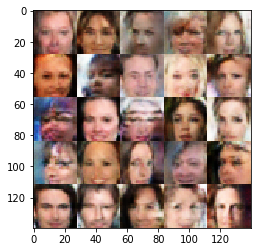

Epoch 6/10... Discriminator Loss: 1.0260... Generator Loss: 1.0488
Epoch 6/10... Discriminator Loss: 1.1285... Generator Loss: 0.9202
Epoch 6/10... Discriminator Loss: 1.0452... Generator Loss: 1.1912
Epoch 6/10... Discriminator Loss: 1.1010... Generator Loss: 0.8789
Epoch 6/10... Discriminator Loss: 0.9942... Generator Loss: 1.1400
Epoch 6/10... Discriminator Loss: 1.2000... Generator Loss: 0.7191
Epoch 6/10... Discriminator Loss: 1.0540... Generator Loss: 0.9552
Epoch 6/10... Discriminator Loss: 1.0592... Generator Loss: 0.8298
Epoch 6/10... Discriminator Loss: 1.1432... Generator Loss: 1.1888
Epoch 6/10... Discriminator Loss: 1.1798... Generator Loss: 0.8612


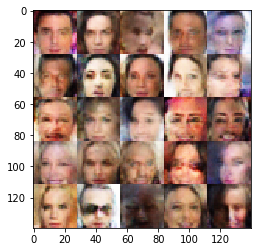

Epoch 6/10... Discriminator Loss: 1.1218... Generator Loss: 1.0058
Epoch 6/10... Discriminator Loss: 1.0078... Generator Loss: 1.1186
Epoch 6/10... Discriminator Loss: 0.8680... Generator Loss: 1.3061
Epoch 6/10... Discriminator Loss: 1.0444... Generator Loss: 1.0690
Epoch 6/10... Discriminator Loss: 1.1933... Generator Loss: 0.7097
Epoch 6/10... Discriminator Loss: 1.1006... Generator Loss: 0.8675
Epoch 6/10... Discriminator Loss: 1.1041... Generator Loss: 0.9465
Epoch 6/10... Discriminator Loss: 1.3260... Generator Loss: 0.5862
Epoch 6/10... Discriminator Loss: 0.9188... Generator Loss: 1.1955
Epoch 6/10... Discriminator Loss: 1.1042... Generator Loss: 1.0462


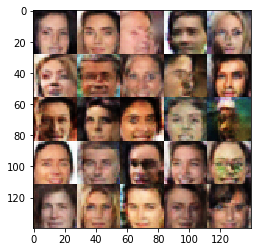

Epoch 6/10... Discriminator Loss: 1.1019... Generator Loss: 1.1023
Epoch 6/10... Discriminator Loss: 1.0428... Generator Loss: 1.2628
Epoch 6/10... Discriminator Loss: 1.0241... Generator Loss: 0.9966
Epoch 6/10... Discriminator Loss: 1.0025... Generator Loss: 1.0604
Epoch 6/10... Discriminator Loss: 1.1780... Generator Loss: 1.0652
Epoch 6/10... Discriminator Loss: 1.0136... Generator Loss: 0.8544
Epoch 6/10... Discriminator Loss: 1.0073... Generator Loss: 1.0541
Epoch 6/10... Discriminator Loss: 1.0143... Generator Loss: 1.2712
Epoch 6/10... Discriminator Loss: 1.1060... Generator Loss: 1.0178
Epoch 6/10... Discriminator Loss: 1.0371... Generator Loss: 1.2009


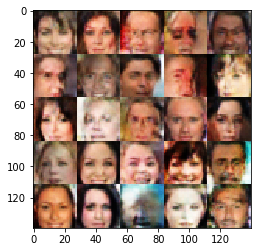

Epoch 6/10... Discriminator Loss: 1.1038... Generator Loss: 0.8307
Epoch 6/10... Discriminator Loss: 1.0505... Generator Loss: 1.2166
Epoch 6/10... Discriminator Loss: 1.0162... Generator Loss: 0.9016
Epoch 6/10... Discriminator Loss: 1.0800... Generator Loss: 1.0468
Epoch 7/10... Discriminator Loss: 1.0567... Generator Loss: 1.2385
Epoch 7/10... Discriminator Loss: 1.0746... Generator Loss: 0.9248
Epoch 7/10... Discriminator Loss: 1.0017... Generator Loss: 0.9756
Epoch 7/10... Discriminator Loss: 1.1151... Generator Loss: 1.3420
Epoch 7/10... Discriminator Loss: 1.1481... Generator Loss: 0.8319
Epoch 7/10... Discriminator Loss: 1.0021... Generator Loss: 1.4675


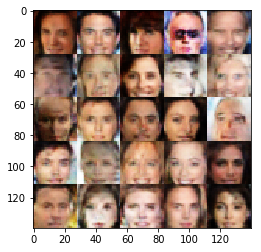

Epoch 7/10... Discriminator Loss: 1.0662... Generator Loss: 1.1706
Epoch 7/10... Discriminator Loss: 1.1993... Generator Loss: 0.9286
Epoch 7/10... Discriminator Loss: 1.0481... Generator Loss: 1.2837
Epoch 7/10... Discriminator Loss: 1.0369... Generator Loss: 1.0887
Epoch 7/10... Discriminator Loss: 1.0151... Generator Loss: 1.2999
Epoch 7/10... Discriminator Loss: 1.1169... Generator Loss: 1.3147
Epoch 7/10... Discriminator Loss: 1.1587... Generator Loss: 0.9679
Epoch 7/10... Discriminator Loss: 1.0944... Generator Loss: 0.9641
Epoch 7/10... Discriminator Loss: 1.1285... Generator Loss: 0.8702
Epoch 7/10... Discriminator Loss: 0.9959... Generator Loss: 1.3147


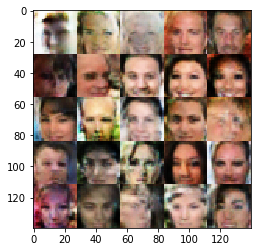

Epoch 7/10... Discriminator Loss: 1.0526... Generator Loss: 0.9840
Epoch 7/10... Discriminator Loss: 1.1355... Generator Loss: 1.1022
Epoch 7/10... Discriminator Loss: 1.0735... Generator Loss: 0.9185
Epoch 7/10... Discriminator Loss: 1.1379... Generator Loss: 0.8744
Epoch 7/10... Discriminator Loss: 1.1572... Generator Loss: 0.8573
Epoch 7/10... Discriminator Loss: 1.2261... Generator Loss: 0.7440
Epoch 7/10... Discriminator Loss: 1.2133... Generator Loss: 1.0025
Epoch 7/10... Discriminator Loss: 1.1055... Generator Loss: 0.9347
Epoch 7/10... Discriminator Loss: 1.1472... Generator Loss: 0.7976
Epoch 7/10... Discriminator Loss: 0.8516... Generator Loss: 1.4604


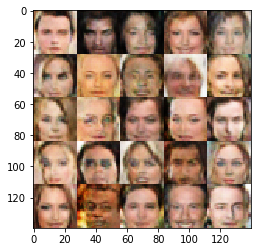

Epoch 7/10... Discriminator Loss: 1.0581... Generator Loss: 1.0652
Epoch 7/10... Discriminator Loss: 1.0913... Generator Loss: 1.3401
Epoch 7/10... Discriminator Loss: 1.1323... Generator Loss: 0.8561
Epoch 7/10... Discriminator Loss: 1.0183... Generator Loss: 0.9440
Epoch 7/10... Discriminator Loss: 0.9770... Generator Loss: 1.0512
Epoch 7/10... Discriminator Loss: 0.9111... Generator Loss: 1.4648
Epoch 7/10... Discriminator Loss: 1.0530... Generator Loss: 1.0246
Epoch 7/10... Discriminator Loss: 1.1735... Generator Loss: 0.8557
Epoch 7/10... Discriminator Loss: 0.9601... Generator Loss: 1.2535
Epoch 7/10... Discriminator Loss: 0.9930... Generator Loss: 1.2013


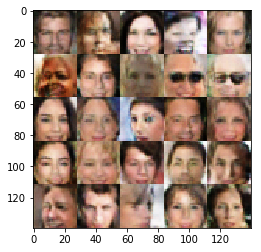

Epoch 7/10... Discriminator Loss: 1.0431... Generator Loss: 0.9856
Epoch 7/10... Discriminator Loss: 1.1505... Generator Loss: 0.7695
Epoch 7/10... Discriminator Loss: 1.2271... Generator Loss: 0.8159
Epoch 7/10... Discriminator Loss: 1.2571... Generator Loss: 0.6076
Epoch 7/10... Discriminator Loss: 1.0671... Generator Loss: 1.0829
Epoch 7/10... Discriminator Loss: 1.0537... Generator Loss: 1.0155
Epoch 7/10... Discriminator Loss: 1.0937... Generator Loss: 1.1477
Epoch 7/10... Discriminator Loss: 1.0156... Generator Loss: 1.2335
Epoch 7/10... Discriminator Loss: 1.2141... Generator Loss: 0.6735
Epoch 7/10... Discriminator Loss: 1.1457... Generator Loss: 1.1230


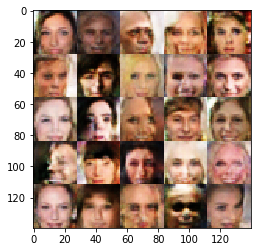

Epoch 7/10... Discriminator Loss: 0.9846... Generator Loss: 1.2265
Epoch 7/10... Discriminator Loss: 1.0247... Generator Loss: 0.9024
Epoch 7/10... Discriminator Loss: 0.9316... Generator Loss: 1.0503
Epoch 7/10... Discriminator Loss: 1.2540... Generator Loss: 1.6118
Epoch 7/10... Discriminator Loss: 1.0580... Generator Loss: 1.0712
Epoch 7/10... Discriminator Loss: 1.1878... Generator Loss: 0.8296
Epoch 7/10... Discriminator Loss: 0.9780... Generator Loss: 1.3789
Epoch 7/10... Discriminator Loss: 1.1851... Generator Loss: 0.8027
Epoch 7/10... Discriminator Loss: 1.0817... Generator Loss: 0.9368
Epoch 7/10... Discriminator Loss: 1.1443... Generator Loss: 1.0198


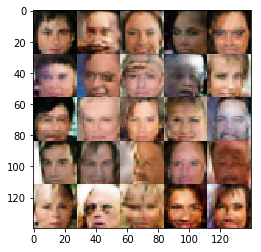

Epoch 7/10... Discriminator Loss: 1.2648... Generator Loss: 0.6946
Epoch 7/10... Discriminator Loss: 1.0571... Generator Loss: 0.9002
Epoch 7/10... Discriminator Loss: 1.0407... Generator Loss: 1.1828
Epoch 7/10... Discriminator Loss: 1.2746... Generator Loss: 0.7918
Epoch 7/10... Discriminator Loss: 1.1334... Generator Loss: 0.9529
Epoch 7/10... Discriminator Loss: 1.0726... Generator Loss: 0.9124
Epoch 7/10... Discriminator Loss: 1.1518... Generator Loss: 0.9194
Epoch 7/10... Discriminator Loss: 1.1266... Generator Loss: 1.2704
Epoch 7/10... Discriminator Loss: 0.9821... Generator Loss: 1.0544
Epoch 7/10... Discriminator Loss: 1.0369... Generator Loss: 1.0301


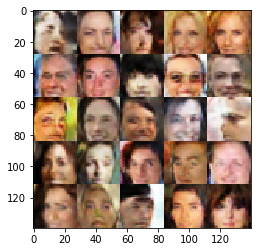

Epoch 7/10... Discriminator Loss: 1.3083... Generator Loss: 0.7398
Epoch 7/10... Discriminator Loss: 1.1380... Generator Loss: 0.9364
Epoch 7/10... Discriminator Loss: 0.9910... Generator Loss: 1.1611
Epoch 7/10... Discriminator Loss: 1.1387... Generator Loss: 0.8548
Epoch 7/10... Discriminator Loss: 1.1716... Generator Loss: 1.1674
Epoch 7/10... Discriminator Loss: 1.1595... Generator Loss: 0.9490
Epoch 7/10... Discriminator Loss: 1.1592... Generator Loss: 0.7817
Epoch 7/10... Discriminator Loss: 0.9541... Generator Loss: 1.0020
Epoch 7/10... Discriminator Loss: 1.1130... Generator Loss: 1.1434
Epoch 7/10... Discriminator Loss: 1.0479... Generator Loss: 0.8961


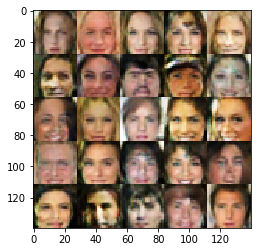

Epoch 7/10... Discriminator Loss: 1.2054... Generator Loss: 1.6208
Epoch 7/10... Discriminator Loss: 0.9634... Generator Loss: 1.0939
Epoch 7/10... Discriminator Loss: 1.2164... Generator Loss: 0.6912
Epoch 8/10... Discriminator Loss: 1.1514... Generator Loss: 0.8858
Epoch 8/10... Discriminator Loss: 1.0057... Generator Loss: 1.1651
Epoch 8/10... Discriminator Loss: 0.9778... Generator Loss: 1.4466
Epoch 8/10... Discriminator Loss: 1.0758... Generator Loss: 0.9104
Epoch 8/10... Discriminator Loss: 1.1109... Generator Loss: 1.2587
Epoch 8/10... Discriminator Loss: 1.2301... Generator Loss: 0.6795
Epoch 8/10... Discriminator Loss: 1.2231... Generator Loss: 0.6512


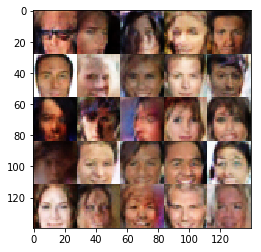

Epoch 8/10... Discriminator Loss: 1.0497... Generator Loss: 0.8902
Epoch 8/10... Discriminator Loss: 1.1144... Generator Loss: 1.0161
Epoch 8/10... Discriminator Loss: 1.0455... Generator Loss: 1.0492
Epoch 8/10... Discriminator Loss: 1.1235... Generator Loss: 1.0597
Epoch 8/10... Discriminator Loss: 1.1765... Generator Loss: 0.7312
Epoch 8/10... Discriminator Loss: 1.0346... Generator Loss: 0.9111
Epoch 8/10... Discriminator Loss: 1.0940... Generator Loss: 0.9311
Epoch 8/10... Discriminator Loss: 1.1108... Generator Loss: 1.0255
Epoch 8/10... Discriminator Loss: 1.0398... Generator Loss: 1.1347
Epoch 8/10... Discriminator Loss: 1.1599... Generator Loss: 0.8201


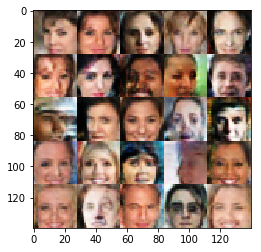

Epoch 8/10... Discriminator Loss: 1.1710... Generator Loss: 0.7695
Epoch 8/10... Discriminator Loss: 1.1582... Generator Loss: 1.0305
Epoch 8/10... Discriminator Loss: 1.2036... Generator Loss: 0.7450
Epoch 8/10... Discriminator Loss: 1.0716... Generator Loss: 1.1341
Epoch 8/10... Discriminator Loss: 1.0939... Generator Loss: 0.8419
Epoch 8/10... Discriminator Loss: 1.1037... Generator Loss: 0.9083
Epoch 8/10... Discriminator Loss: 1.1164... Generator Loss: 0.8195
Epoch 8/10... Discriminator Loss: 0.9853... Generator Loss: 1.2365
Epoch 8/10... Discriminator Loss: 1.1417... Generator Loss: 0.7703
Epoch 8/10... Discriminator Loss: 1.1586... Generator Loss: 0.7192


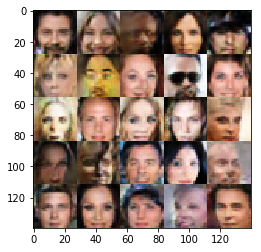

Epoch 8/10... Discriminator Loss: 1.1177... Generator Loss: 0.8909
Epoch 8/10... Discriminator Loss: 0.9810... Generator Loss: 1.5447
Epoch 8/10... Discriminator Loss: 1.1069... Generator Loss: 0.8162
Epoch 8/10... Discriminator Loss: 0.9292... Generator Loss: 1.2007
Epoch 8/10... Discriminator Loss: 1.4615... Generator Loss: 0.4600
Epoch 8/10... Discriminator Loss: 1.2063... Generator Loss: 0.8640
Epoch 8/10... Discriminator Loss: 1.1068... Generator Loss: 0.8967
Epoch 8/10... Discriminator Loss: 1.1730... Generator Loss: 0.8955
Epoch 8/10... Discriminator Loss: 1.1258... Generator Loss: 0.8952
Epoch 8/10... Discriminator Loss: 1.0913... Generator Loss: 0.9891


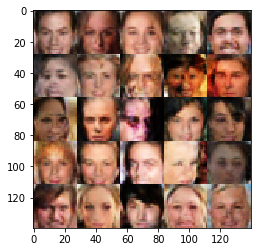

Epoch 8/10... Discriminator Loss: 1.2231... Generator Loss: 1.4253
Epoch 8/10... Discriminator Loss: 1.0954... Generator Loss: 1.1488
Epoch 8/10... Discriminator Loss: 1.1530... Generator Loss: 1.1199
Epoch 8/10... Discriminator Loss: 1.1354... Generator Loss: 0.8133
Epoch 8/10... Discriminator Loss: 1.2224... Generator Loss: 0.8381
Epoch 8/10... Discriminator Loss: 1.0099... Generator Loss: 1.0311
Epoch 8/10... Discriminator Loss: 1.3006... Generator Loss: 0.7248
Epoch 8/10... Discriminator Loss: 0.9965... Generator Loss: 0.9494
Epoch 8/10... Discriminator Loss: 1.0904... Generator Loss: 0.8976
Epoch 8/10... Discriminator Loss: 1.0904... Generator Loss: 1.1094


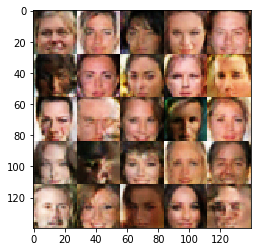

Epoch 8/10... Discriminator Loss: 1.1271... Generator Loss: 0.7304
Epoch 8/10... Discriminator Loss: 0.9874... Generator Loss: 1.3010
Epoch 8/10... Discriminator Loss: 1.1646... Generator Loss: 0.7610
Epoch 8/10... Discriminator Loss: 1.0331... Generator Loss: 1.0965
Epoch 8/10... Discriminator Loss: 1.0069... Generator Loss: 1.2209
Epoch 8/10... Discriminator Loss: 1.6080... Generator Loss: 0.4515
Epoch 8/10... Discriminator Loss: 1.2653... Generator Loss: 0.6619
Epoch 8/10... Discriminator Loss: 0.9935... Generator Loss: 1.1577
Epoch 8/10... Discriminator Loss: 1.0458... Generator Loss: 1.0348
Epoch 8/10... Discriminator Loss: 1.2642... Generator Loss: 0.8104


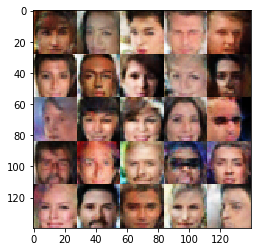

Epoch 8/10... Discriminator Loss: 1.1044... Generator Loss: 1.0988
Epoch 8/10... Discriminator Loss: 1.1272... Generator Loss: 0.7673
Epoch 8/10... Discriminator Loss: 1.1129... Generator Loss: 0.8011
Epoch 8/10... Discriminator Loss: 1.0413... Generator Loss: 1.0460
Epoch 8/10... Discriminator Loss: 1.0154... Generator Loss: 0.9949
Epoch 8/10... Discriminator Loss: 1.0773... Generator Loss: 0.8599
Epoch 8/10... Discriminator Loss: 1.2063... Generator Loss: 0.7793
Epoch 8/10... Discriminator Loss: 1.0309... Generator Loss: 1.1903
Epoch 8/10... Discriminator Loss: 1.0187... Generator Loss: 1.0003
Epoch 8/10... Discriminator Loss: 1.1205... Generator Loss: 0.8326


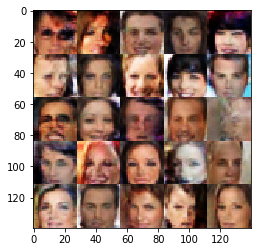

Epoch 8/10... Discriminator Loss: 0.9819... Generator Loss: 1.1243
Epoch 8/10... Discriminator Loss: 1.0892... Generator Loss: 1.1266
Epoch 8/10... Discriminator Loss: 1.1151... Generator Loss: 1.0776
Epoch 8/10... Discriminator Loss: 1.0378... Generator Loss: 0.9662
Epoch 8/10... Discriminator Loss: 1.0944... Generator Loss: 1.0089
Epoch 8/10... Discriminator Loss: 1.0983... Generator Loss: 0.8567
Epoch 8/10... Discriminator Loss: 1.1425... Generator Loss: 1.0315
Epoch 8/10... Discriminator Loss: 0.8789... Generator Loss: 1.2257
Epoch 8/10... Discriminator Loss: 1.0683... Generator Loss: 1.0635
Epoch 8/10... Discriminator Loss: 1.1984... Generator Loss: 0.7574


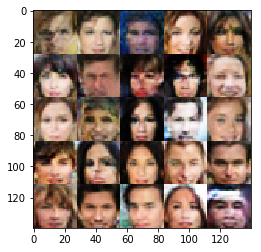

Epoch 8/10... Discriminator Loss: 1.0813... Generator Loss: 1.0114
Epoch 8/10... Discriminator Loss: 1.0762... Generator Loss: 0.9247
Epoch 9/10... Discriminator Loss: 1.0799... Generator Loss: 0.9818
Epoch 9/10... Discriminator Loss: 1.0268... Generator Loss: 1.0308
Epoch 9/10... Discriminator Loss: 1.1956... Generator Loss: 0.8398
Epoch 9/10... Discriminator Loss: 1.0830... Generator Loss: 0.9926
Epoch 9/10... Discriminator Loss: 1.1890... Generator Loss: 0.7355
Epoch 9/10... Discriminator Loss: 1.0750... Generator Loss: 0.8795
Epoch 9/10... Discriminator Loss: 0.9158... Generator Loss: 1.5289
Epoch 9/10... Discriminator Loss: 1.0285... Generator Loss: 1.1129


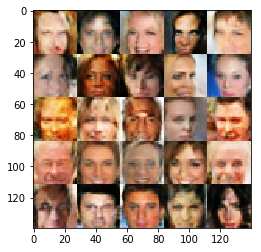

Epoch 9/10... Discriminator Loss: 1.1649... Generator Loss: 0.7642
Epoch 9/10... Discriminator Loss: 1.0550... Generator Loss: 0.9176
Epoch 9/10... Discriminator Loss: 0.9779... Generator Loss: 1.0810
Epoch 9/10... Discriminator Loss: 1.0465... Generator Loss: 0.9525
Epoch 9/10... Discriminator Loss: 1.1407... Generator Loss: 1.3867
Epoch 9/10... Discriminator Loss: 1.0212... Generator Loss: 1.0452
Epoch 9/10... Discriminator Loss: 1.0954... Generator Loss: 1.3061
Epoch 9/10... Discriminator Loss: 1.0937... Generator Loss: 1.3109
Epoch 9/10... Discriminator Loss: 1.1830... Generator Loss: 0.7374
Epoch 9/10... Discriminator Loss: 1.1065... Generator Loss: 1.4630


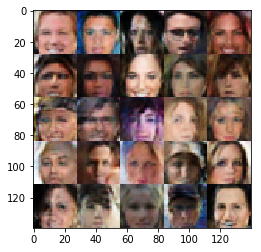

Epoch 9/10... Discriminator Loss: 1.1735... Generator Loss: 0.8323
Epoch 9/10... Discriminator Loss: 1.1027... Generator Loss: 1.3250
Epoch 9/10... Discriminator Loss: 1.1578... Generator Loss: 1.3886
Epoch 9/10... Discriminator Loss: 1.0321... Generator Loss: 1.1179
Epoch 9/10... Discriminator Loss: 1.1568... Generator Loss: 0.9104
Epoch 9/10... Discriminator Loss: 0.9962... Generator Loss: 1.1810
Epoch 9/10... Discriminator Loss: 1.1233... Generator Loss: 0.9724
Epoch 9/10... Discriminator Loss: 0.9498... Generator Loss: 1.2200
Epoch 9/10... Discriminator Loss: 1.1349... Generator Loss: 1.0352
Epoch 9/10... Discriminator Loss: 0.9530... Generator Loss: 1.0766


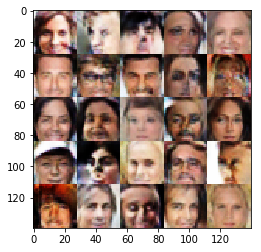

Epoch 9/10... Discriminator Loss: 1.1178... Generator Loss: 0.9468
Epoch 9/10... Discriminator Loss: 1.1332... Generator Loss: 1.5892
Epoch 9/10... Discriminator Loss: 1.0761... Generator Loss: 1.0909
Epoch 9/10... Discriminator Loss: 1.1379... Generator Loss: 0.7482
Epoch 9/10... Discriminator Loss: 1.0744... Generator Loss: 0.9361
Epoch 9/10... Discriminator Loss: 1.0657... Generator Loss: 0.8867
Epoch 9/10... Discriminator Loss: 1.0471... Generator Loss: 1.0447
Epoch 9/10... Discriminator Loss: 1.1702... Generator Loss: 0.8356
Epoch 9/10... Discriminator Loss: 1.1622... Generator Loss: 1.2003
Epoch 9/10... Discriminator Loss: 1.2802... Generator Loss: 1.3072


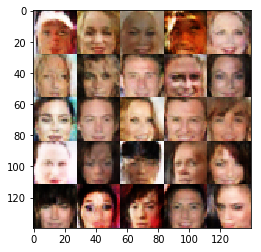

Epoch 9/10... Discriminator Loss: 1.2369... Generator Loss: 0.7150
Epoch 9/10... Discriminator Loss: 1.0001... Generator Loss: 0.9203
Epoch 9/10... Discriminator Loss: 0.9567... Generator Loss: 1.3515
Epoch 9/10... Discriminator Loss: 1.1396... Generator Loss: 0.8818
Epoch 9/10... Discriminator Loss: 1.0053... Generator Loss: 0.9622
Epoch 9/10... Discriminator Loss: 0.9487... Generator Loss: 1.1588
Epoch 9/10... Discriminator Loss: 0.9794... Generator Loss: 1.2302
Epoch 9/10... Discriminator Loss: 1.0936... Generator Loss: 1.0373
Epoch 9/10... Discriminator Loss: 0.9734... Generator Loss: 1.1633
Epoch 9/10... Discriminator Loss: 0.9426... Generator Loss: 1.1803


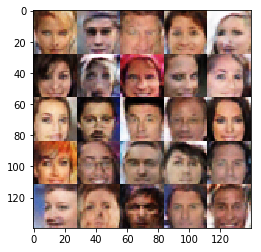

Epoch 9/10... Discriminator Loss: 1.1343... Generator Loss: 0.7741
Epoch 9/10... Discriminator Loss: 1.0402... Generator Loss: 0.9347
Epoch 9/10... Discriminator Loss: 0.9588... Generator Loss: 0.9444
Epoch 9/10... Discriminator Loss: 1.1002... Generator Loss: 0.7608
Epoch 9/10... Discriminator Loss: 1.0683... Generator Loss: 1.0001
Epoch 9/10... Discriminator Loss: 0.9480... Generator Loss: 1.2087
Epoch 9/10... Discriminator Loss: 1.0636... Generator Loss: 0.9572
Epoch 9/10... Discriminator Loss: 1.1548... Generator Loss: 0.6919
Epoch 9/10... Discriminator Loss: 1.0740... Generator Loss: 1.0040
Epoch 9/10... Discriminator Loss: 1.0441... Generator Loss: 1.5248


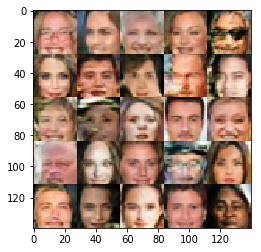

Epoch 9/10... Discriminator Loss: 0.9417... Generator Loss: 1.5257
Epoch 9/10... Discriminator Loss: 1.1336... Generator Loss: 0.9628
Epoch 9/10... Discriminator Loss: 1.1724... Generator Loss: 0.7591
Epoch 9/10... Discriminator Loss: 1.0190... Generator Loss: 1.1679
Epoch 9/10... Discriminator Loss: 0.8758... Generator Loss: 1.1564
Epoch 9/10... Discriminator Loss: 1.0062... Generator Loss: 1.3212
Epoch 9/10... Discriminator Loss: 1.1136... Generator Loss: 1.0776
Epoch 9/10... Discriminator Loss: 1.0508... Generator Loss: 1.3502
Epoch 9/10... Discriminator Loss: 1.0191... Generator Loss: 1.3992
Epoch 9/10... Discriminator Loss: 1.2745... Generator Loss: 0.6492


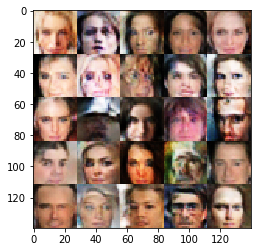

Epoch 9/10... Discriminator Loss: 1.1733... Generator Loss: 0.7665
Epoch 9/10... Discriminator Loss: 1.1950... Generator Loss: 0.7741
Epoch 9/10... Discriminator Loss: 0.9891... Generator Loss: 1.0818
Epoch 9/10... Discriminator Loss: 0.9926... Generator Loss: 1.2667
Epoch 9/10... Discriminator Loss: 1.1259... Generator Loss: 1.2967
Epoch 9/10... Discriminator Loss: 1.0584... Generator Loss: 0.9757
Epoch 9/10... Discriminator Loss: 0.9637... Generator Loss: 1.0868
Epoch 9/10... Discriminator Loss: 1.2282... Generator Loss: 0.8056
Epoch 9/10... Discriminator Loss: 1.3136... Generator Loss: 1.1453
Epoch 9/10... Discriminator Loss: 1.0886... Generator Loss: 0.8963


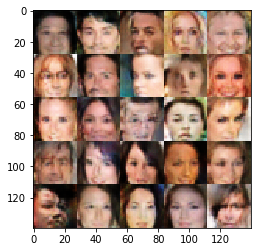

Epoch 9/10... Discriminator Loss: 1.2788... Generator Loss: 0.7191
Epoch 10/10... Discriminator Loss: 1.0790... Generator Loss: 1.3300
Epoch 10/10... Discriminator Loss: 1.4135... Generator Loss: 1.9606
Epoch 10/10... Discriminator Loss: 1.0260... Generator Loss: 1.0730
Epoch 10/10... Discriminator Loss: 1.1808... Generator Loss: 0.9380
Epoch 10/10... Discriminator Loss: 1.0487... Generator Loss: 1.1571
Epoch 10/10... Discriminator Loss: 1.1778... Generator Loss: 0.7770
Epoch 10/10... Discriminator Loss: 1.0821... Generator Loss: 0.9011
Epoch 10/10... Discriminator Loss: 1.0185... Generator Loss: 0.9580
Epoch 10/10... Discriminator Loss: 1.0161... Generator Loss: 0.9047


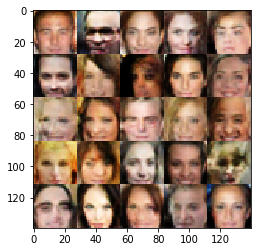

Epoch 10/10... Discriminator Loss: 1.0517... Generator Loss: 0.9531
Epoch 10/10... Discriminator Loss: 1.1090... Generator Loss: 0.8259
Epoch 10/10... Discriminator Loss: 0.9753... Generator Loss: 1.2297
Epoch 10/10... Discriminator Loss: 1.0859... Generator Loss: 0.9056
Epoch 10/10... Discriminator Loss: 1.2174... Generator Loss: 0.9088
Epoch 10/10... Discriminator Loss: 1.1453... Generator Loss: 0.7178
Epoch 10/10... Discriminator Loss: 1.1497... Generator Loss: 0.8439
Epoch 10/10... Discriminator Loss: 1.0099... Generator Loss: 1.2465
Epoch 10/10... Discriminator Loss: 1.1086... Generator Loss: 0.8355
Epoch 10/10... Discriminator Loss: 1.0294... Generator Loss: 0.8658


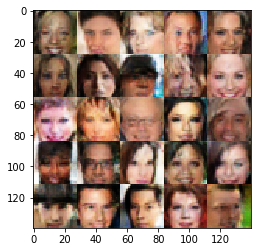

Epoch 10/10... Discriminator Loss: 1.3418... Generator Loss: 0.6249
Epoch 10/10... Discriminator Loss: 1.2040... Generator Loss: 0.6757
Epoch 10/10... Discriminator Loss: 1.2649... Generator Loss: 1.0325
Epoch 10/10... Discriminator Loss: 1.0612... Generator Loss: 1.1401
Epoch 10/10... Discriminator Loss: 1.0954... Generator Loss: 0.8460
Epoch 10/10... Discriminator Loss: 1.2200... Generator Loss: 1.1108
Epoch 10/10... Discriminator Loss: 1.0957... Generator Loss: 0.8063
Epoch 10/10... Discriminator Loss: 1.1389... Generator Loss: 0.8768
Epoch 10/10... Discriminator Loss: 1.2257... Generator Loss: 0.7373
Epoch 10/10... Discriminator Loss: 0.9997... Generator Loss: 1.0146


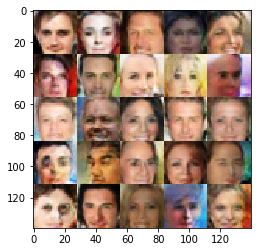

Epoch 10/10... Discriminator Loss: 1.1182... Generator Loss: 1.2571
Epoch 10/10... Discriminator Loss: 1.1371... Generator Loss: 0.8074
Epoch 10/10... Discriminator Loss: 1.0540... Generator Loss: 1.1495
Epoch 10/10... Discriminator Loss: 1.1383... Generator Loss: 0.8420
Epoch 10/10... Discriminator Loss: 1.1130... Generator Loss: 0.9456
Epoch 10/10... Discriminator Loss: 0.9930... Generator Loss: 1.5160
Epoch 10/10... Discriminator Loss: 1.0628... Generator Loss: 1.0165
Epoch 10/10... Discriminator Loss: 0.9590... Generator Loss: 1.0701
Epoch 10/10... Discriminator Loss: 1.1162... Generator Loss: 0.8378
Epoch 10/10... Discriminator Loss: 1.0629... Generator Loss: 0.8423


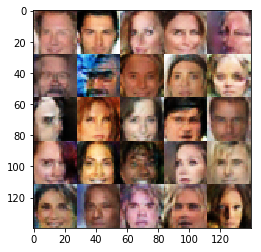

Epoch 10/10... Discriminator Loss: 0.9978... Generator Loss: 1.0576
Epoch 10/10... Discriminator Loss: 1.2491... Generator Loss: 0.6816
Epoch 10/10... Discriminator Loss: 1.0791... Generator Loss: 1.2951
Epoch 10/10... Discriminator Loss: 1.1681... Generator Loss: 1.0931
Epoch 10/10... Discriminator Loss: 1.0802... Generator Loss: 1.0660
Epoch 10/10... Discriminator Loss: 1.0852... Generator Loss: 0.8525
Epoch 10/10... Discriminator Loss: 1.1657... Generator Loss: 0.7399
Epoch 10/10... Discriminator Loss: 1.2422... Generator Loss: 0.6859
Epoch 10/10... Discriminator Loss: 1.2332... Generator Loss: 1.0589
Epoch 10/10... Discriminator Loss: 0.9420... Generator Loss: 1.1837


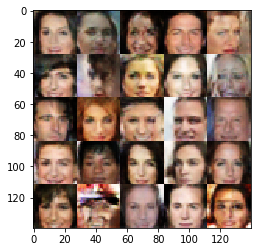

Epoch 10/10... Discriminator Loss: 1.2412... Generator Loss: 0.7224
Epoch 10/10... Discriminator Loss: 1.0617... Generator Loss: 1.0825
Epoch 10/10... Discriminator Loss: 0.9443... Generator Loss: 1.2386
Epoch 10/10... Discriminator Loss: 0.9838... Generator Loss: 1.1251
Epoch 10/10... Discriminator Loss: 1.0801... Generator Loss: 0.8539
Epoch 10/10... Discriminator Loss: 1.1572... Generator Loss: 0.7561
Epoch 10/10... Discriminator Loss: 0.9960... Generator Loss: 1.1136
Epoch 10/10... Discriminator Loss: 1.2228... Generator Loss: 0.6876
Epoch 10/10... Discriminator Loss: 0.9998... Generator Loss: 1.1223
Epoch 10/10... Discriminator Loss: 1.1410... Generator Loss: 0.9449


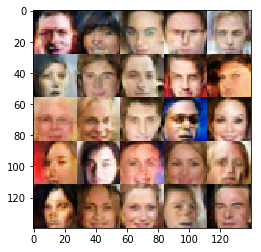

Epoch 10/10... Discriminator Loss: 1.0514... Generator Loss: 0.8339
Epoch 10/10... Discriminator Loss: 1.1010... Generator Loss: 1.0251
Epoch 10/10... Discriminator Loss: 1.1653... Generator Loss: 0.9030
Epoch 10/10... Discriminator Loss: 1.1054... Generator Loss: 0.9774
Epoch 10/10... Discriminator Loss: 1.1551... Generator Loss: 1.2143
Epoch 10/10... Discriminator Loss: 1.1228... Generator Loss: 0.8253
Epoch 10/10... Discriminator Loss: 1.2628... Generator Loss: 0.6694
Epoch 10/10... Discriminator Loss: 1.1967... Generator Loss: 0.7928
Epoch 10/10... Discriminator Loss: 1.0830... Generator Loss: 1.1559
Epoch 10/10... Discriminator Loss: 1.0148... Generator Loss: 1.0859


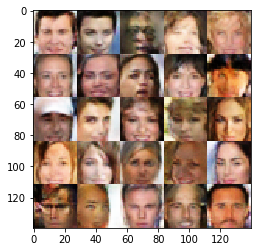

Epoch 10/10... Discriminator Loss: 1.2020... Generator Loss: 0.7700
Epoch 10/10... Discriminator Loss: 1.0570... Generator Loss: 0.7851
Epoch 10/10... Discriminator Loss: 1.1058... Generator Loss: 1.0244
Epoch 10/10... Discriminator Loss: 1.1390... Generator Loss: 0.8002
Epoch 10/10... Discriminator Loss: 1.1446... Generator Loss: 0.8835
Epoch 10/10... Discriminator Loss: 1.0754... Generator Loss: 1.4118
Epoch 10/10... Discriminator Loss: 1.2063... Generator Loss: 0.6352
Epoch 10/10... Discriminator Loss: 1.0289... Generator Loss: 0.9270
Epoch 10/10... Discriminator Loss: 1.1471... Generator Loss: 1.1206
Epoch 10/10... Discriminator Loss: 1.2292... Generator Loss: 0.8287


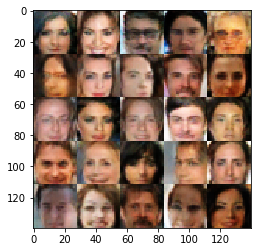

Epoch 10/10... Discriminator Loss: 1.3581... Generator Loss: 0.5262


In [13]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.